In [118]:
import pandas as pd
import numpy as np
import glob
import os
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
from datetime import datetime as dt
import unidecode
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion, make_union


import re
import pickle

from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer 

from sklearn.model_selection import cross_val_score,train_test_split,GridSearchCV

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

from scipy.sparse import hstack
from scipy.special import logit, expit

# from my_nmf import NMF
from helpers import build_text_vectorizer, hand_label_topics, analyze_article

plt.style.use('seaborn')
# os.chdir("data")

In [7]:
file = 'data/comments.csv'
df = pd.read_csv(file, names = ['Text', 'ID', 'Subreddit', 'meta', 'Time', 'Username', 'Upvotes', 'Downvotes', 'Author_link_karma', 'Author_Comment_Karma','Author_has_gold?'], parse_dates =True)


In [8]:
df

,Text,ID,Subreddit,meta,Time,Username,Upvotes,Downvotes,Author_link_karma,Author_Comment_Karma,Author_has_gold?
0,NaN,4644c4,libertarian,news,1.455651e+09,DrWinters,3.0,0.0,12728.0,1641.0,0.0
1,NaN,464kvf,libertarian,news,1.455657e+09,unknownman19,20.0,0.0,50364.0,14436.0,0.0
2,NaN,466hv9,libertarian,news,1.455683e+09,hp_chabanais,1.0,0.0,178.0,3.0,0.0
3,NaN,462wog,libertarian,news,1.455636e+09,ghostofpennwast,18.0,0.0,231424.0,80539.0,1.0
4,disclaimer : i think obama should nominate som...,d028c5d,politics,news,1.455651e+09,degausse,3.0,0.0,1.0,1941.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2725995,for those with a woefully bad sense of directi...,d02c1s1,minecraft,gaming,1.455656e+09,capfan67,2.0,0.0,178.0,2518.0,0.0
2725996,the characters hand in first person is invisib...,464kj4,minecraft,gaming,1.455656e+09,CookiezFort,0.0,0.0,833.0,3248.0,0.0
2725997,i guess either the shaders use some feature th...,d02cxvk,minecraft,gaming,1.455657e+09,Huntron,1.0,0.0,5534.0,3062.0,1.0
2725998,my guess is that you 're trying to use a brand...,d02ic1n,minecraft,gaming,1.455664e+09,nothingl_,1.0,0.0,104.0,807.0,0.0


In [9]:
df2 = df.copy()

In [10]:
df2 = df2.dropna(axis =0)

In [11]:
df_test = df2.copy()

In [12]:
df_test



,Text,ID,Subreddit,meta,Time,Username,Upvotes,Downvotes,Author_link_karma,Author_Comment_Karma,Author_has_gold?
4,disclaimer : i think obama should nominate som...,d028c5d,politics,news,1.455651e+09,degausse,3.0,0.0,1.0,1941.0,0.0
6,either way the process will be dragged out unt...,d026od6,politics,news,1.455648e+09,cyberspyder,5.0,0.0,1300.0,6462.0,1.0
7,republicans have always battled with severe ca...,d026wk3,politics,news,1.455649e+09,jabb0,15.0,0.0,44981.0,141501.0,0.0
8,politics were so different back then. people o...,d02a3k3,politics,news,1.455653e+09,Hypertension123456,2.0,0.0,46.0,42036.0,0.0
9,"equally ridiculous , here 's a 1970 law review...",d025wad,politics,news,1.455647e+09,trash_reason,26.0,0.0,5613.0,1361.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2725995,for those with a woefully bad sense of directi...,d02c1s1,minecraft,gaming,1.455656e+09,capfan67,2.0,0.0,178.0,2518.0,0.0
2725996,the characters hand in first person is invisib...,464kj4,minecraft,gaming,1.455656e+09,CookiezFort,0.0,0.0,833.0,3248.0,0.0
2725997,i guess either the shaders use some feature th...,d02cxvk,minecraft,gaming,1.455657e+09,Huntron,1.0,0.0,5534.0,3062.0,1.0
2725998,my guess is that you 're trying to use a brand...,d02ic1n,minecraft,gaming,1.455664e+09,nothingl_,1.0,0.0,104.0,807.0,0.0


# pipeline


In [13]:
punctuations = '''.!=()[]{};:'"|\<>/?@#$%^&*_~'''
replace = '\n'


lst = []
for i in df_test.Text.values:
    no_punct = ""
#     if len(i) > 15:
#         continue
    for char in i:
        if char in replace:
            char = " "
        if char not in punctuations:
           no_punct = f'{no_punct + char }'
  
        
    lst.append(no_punct)


In [14]:
df_test.Text = lst
df_test

,Text,ID,Subreddit,meta,Time,Username,Upvotes,Downvotes,Author_link_karma,Author_Comment_Karma,Author_has_gold?
4,disclaimer i think obama should nominate some...,d028c5d,politics,news,1.455651e+09,degausse,3.0,0.0,1.0,1941.0,0.0
6,either way the process will be dragged out unt...,d026od6,politics,news,1.455648e+09,cyberspyder,5.0,0.0,1300.0,6462.0,1.0
7,republicans have always battled with severe ca...,d026wk3,politics,news,1.455649e+09,jabb0,15.0,0.0,44981.0,141501.0,0.0
8,politics were so different back then people on...,d02a3k3,politics,news,1.455653e+09,Hypertension123456,2.0,0.0,46.0,42036.0,0.0
9,"equally ridiculous , here s a 1970 law review ...",d025wad,politics,news,1.455647e+09,trash_reason,26.0,0.0,5613.0,1361.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2725995,for those with a woefully bad sense of directi...,d02c1s1,minecraft,gaming,1.455656e+09,capfan67,2.0,0.0,178.0,2518.0,0.0
2725996,the characters hand in first person is invisib...,464kj4,minecraft,gaming,1.455656e+09,CookiezFort,0.0,0.0,833.0,3248.0,0.0
2725997,i guess either the shaders use some feature th...,d02cxvk,minecraft,gaming,1.455657e+09,Huntron,1.0,0.0,5534.0,3062.0,1.0
2725998,my guess is that you re trying to use a brand ...,d02ic1n,minecraft,gaming,1.455664e+09,nothingl_,1.0,0.0,104.0,807.0,0.0


In [15]:
s_stop = set(stopwords.words())
new_stops = ['2015ref','publisherspage190ref','volume9', 'issue2', 'page7','logo.png','2015.ref', 'nameleaf200kcit','ref', '005.jpgthumbrightth', 'whose', 'kind','png', 'jpg', 'wiktionaryzero', 'wiktionaryzero0', 'wiktionaryzero0', 'articlesquantum','0supsup', '0refcit', '1-3', 'redirectzero', '.', ',', 'nameleaf200k2cit', 'wiktionari', 'namecarb01cit','-', 'filezero', 'mvaramvarxmvari', 'page98','datemfyes1915228', 'year1989ref', '1671.jpgthumbemerg', 'refimprovedatemay','ligatureligatur', 'pppc1expiry2144', 'wiktionary','wiktionary0', 'n','improvedateoctob' ]
for i in new_stops:
    s_stop.add(i)
len(s_stop)
new_stop = s_stop
len(new_stops)

41

In [16]:
lst_stems = []
for i in df_test.Text:
    i = i.lower()
    i = unidecode.unidecode(i)
    l_s = sent_tokenize(i)
#     print("Sentence Tokens:\n",l_s[:2])

    tokens = list(map(word_tokenize, l_s))
#     print("\nWord Tokens:\n", tokens[:2])

    
    tokens_stop_free = [[word for word in sent if word not in new_stop] for sent in tokens]
#     print("\nNo stop word tokens:\n", tokens_stop_free[:2])

    st = SnowballStemmer(language = 'english')
    stems = [[st.stem(word) for word in sent] for sent in tokens_stop_free]
    try:
        stems_no_dupes = (stems[0])
    except:
        stems_no_dupes = stems
#     break
#     print("\nNo stop word tokens:\n", stems[:2])
    lst_stems.append(" ".join(stems_no_dupes))
stems_no_dupes

['run',
 '18',
 'server',
 'ever',
 'sinc',
 '16',
 'server',
 'skip',
 'everi',
 'half-second',
 'game',
 'mean',
 'everyon',
 'play',
 'skip',
 'mild',
 'frustrat',
 'server',
 'window',
 'skip',
 'drag',
 'around',
 'desktop',
 'hard',
 'explain',
 'exact',
 'what',
 'happen',
 'wonder',
 'anyon',
 'solut',
 'experienc',
 'search',
 'googl',
 'noth',
 'exact',
 'match',
 'problem']

# Cleaned data read into clean csv


In [17]:
df_test_snowball = df_test.copy()
df_test_snowball.Text = lst_stems
df_test_snowball.to_csv('Cleaned_comments', index = False)

In [2]:
clean_df = pd.read_csv('Cleaned_comments.csv')

In [12]:
clean_df2=clean_df.dropna(axis=0)

# NMF

In [13]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

vectorized = tfidf_vectorizer.fit_transform(clean_df2['Text'])

In [14]:
tfidf_vectorizer.get_feature_names()

['00',
 '000',
 '00000',
 '0000000031',
 '0000000642',
 '00000031',
 '00001',
 '00001001',
 '0000110',
 '00001g',
 '0001',
 '00026',
 '0004',
 '00063',
 '000bike',
 '000pull',
 '000sqft',
 '001',
 '00100000',
 '0011',
 '0015',
 '001c',
 '001jpg',
 '002',
 '003',
 '0033',
 '004',
 '005',
 '006225133476456637497',
 '007',
 '0079',
 '0080',
 '00800',
 '0088',
 '008jpg',
 '009',
 '00am',
 '00cst',
 '00gmt',
 '00pm',
 '00s',
 '01',
 '010',
 '01000001',
 '0103',
 '01100101',
 '01101000',
 '01101100',
 '01101111',
 '011915',
 '013',
 '014',
 '0140',
 '015',
 '016',
 '017',
 '01h29m41s',
 '01h41m51s',
 '01jpg',
 '01k',
 '02',
 '020',
 '021',
 '02102016',
 '0217',
 '0225',
 '0227',
 '023',
 '025',
 '028',
 '02933',
 '02937',
 '02fo',
 '02h13m39s',
 '02h26m08s',
 '03',
 '03231',
 '033',
 '0343',
 '036',
 '037',
 '038',
 '039',
 '03c12578',
 '03h10m20s',
 '03x0bu2w9hi',
 '04',
 '04042010',
 '042',
 '04e24f49b4d7b52aamp',
 '04e88fed000005dc',
 '04gif',
 '04jpg',
 '04mnf1ydnxi',
 '04putin',
 '05',


In [29]:
from sklearn.decomposition import NMF

model = NMF(n_components=2, init='random', random_state=0)
W = model.fit_transform(vectorized)
H = model.components_

def fit_nmf(r):
    nmf = NMF(n_components=r)
    nmf.fit(vectorized)
    W = nmf.transform(vectorized)
    H = nmf.components_
    return nmf.reconstruction_err_

In [28]:
vectorized

<2497636x49076 sparse matrix of type '<class 'numpy.float64'>'
	with 34722856 stored elements in Compressed Sparse Row format>

Text(0, 0.5, 'Reconstruction Errror')

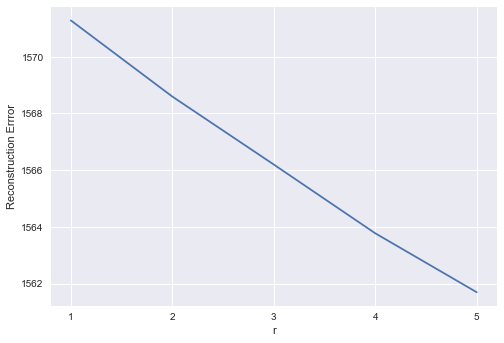

In [30]:
error = [fit_nmf(i) for i in range(1,6)]
plt.plot(range(1,6), error)
plt.xticks(range(1, 6))
plt.xlabel('r')
plt.ylabel('Reconstruction Errror')

# Random Forest 

In [46]:
clean_df = clean_df.dropna(axis=0)

In [97]:
df_select = clean_df.loc[clean_df['Subreddit'] == 'entertainment']
df_select

,Text,ID,Subreddit,meta,Time,Username,Upvotes,Downvotes,Author_link_karma,Author_Comment_Karma,Author_has_gold?
1306620,wait see whoop intergalact alien butt rogu who...,d02nuw8,movies,entertainment,1.455673e+09,cmonster1697,1.0,0.0,488.0,8426.0,0.0
1306621,amaz cinematograph best ever,d02q51i,movies,entertainment,1.455676e+09,BrodoFagginsIsMyName,1.0,0.0,1.0,457.0,0.0
1306622,final life chang,d02uuym,movies,entertainment,1.455684e+09,BrodoFagginsIsMyName,3.0,0.0,1.0,457.0,0.0
1306623,awesom thank,d02ftgc,movies,entertainment,1.455661e+09,JeopardyThis,3.0,0.0,1.0,-7.0,0.0
1306624,tom cruis charact john anderton kidnap pre-cog...,465qz3,movies,entertainment,1.455672e+09,tangowhiskey33,16.0,0.0,7346.0,6138.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1664682,love,d026lj4,harrypotter,entertainment,1.455648e+09,elbowsss,2.0,0.0,2212.0,8637.0,1.0
1664683,type ra hope manag get select current ras grea...,d02qfaf,harrypotter,entertainment,1.455677e+09,DEP61,2.0,0.0,5581.0,13488.0,0.0
1664684,bulletin board month p http iimgurcom7h3pfuyjpg,d02rem2,harrypotter,entertainment,1.455678e+09,laneebird,2.0,0.0,43.0,8.0,0.0
1664685,excel would pleas find first day great job,d02ecuj,harrypotter,entertainment,1.455659e+09,GoodniteMush,1.0,0.0,1.0,681.0,0.0


In [133]:
X = df_select['Text']
y = df_select['Subreddit']

In [134]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.33,
                                                    random_state=0)

In [152]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words=s_stop, max_features =5000 )
vec_X_train = tfidf_vectorizer.fit_transform(X_train)
vec_X_test = tfidf_vectorizer.fit_transform(X_test)

In [153]:
# Train and fit model                                                   
rf = RandomForestClassifier(random_state=0,n_jobs=10, max_features = 'sqrt')

rf.fit(vec_X_train, y_train)
                                     
# Test Prediction
pred = rf.predict(vec_X_test)
print('Accuracy score: {:.3}'.format(rf.score(vec_X_test, y_test)))

Accuracy score: 0.224


In [ ]:
full_class_names = ['entertainment_anime.csv', 'entertainment_comicbooks.csv', 'entertainment_harrypotter.csv', 'entertainment_movies.csv', 'entertainment_music.csv', 'entertainment_starwars.csv', 'gaming_dota2.csv','gaming_gaming.csv', 'gaming_leagueoflegends.csv','gaming_minecraft.csv','gaming_pokemon.csv','gaming_skyrim.csv','gaming_starcraft.csv', 'gaming_tf2.csv','humor_adviceanimals.csv', 'humor_circlejerk.csv', 'humor_facepalm.csv','humor_funny.csv','humor_imgoingtohellforthis.csv','humor_jokes.csv', 'learning_askhistorians.csv','learning_askscience.csv','learning_explainlikeimfive.csv', 'learning_science.csv', 'learning_space.csv', 'learning_todayilearned.csv', 'learning_youshouldknow.csv', 'lifestyle_drunk.csv', 'lifestyle_food.csv', 'lifestyle_frugal.csv', 'lifestyle_guns.csv','lifestyle_lifehacks.csv','lifestyle_motorcycles.csv','lifestyle_progresspics.csv', 'lifestyle_sex.csv','news_conservative.csv','news_conspiracy.csv', 'news_libertarian.csv', 'news_news.csv','news_offbeat.csv','news_politics.csv', 'news_truereddit.csv', 'news_worldnews.csv','television_breakingbad.csv','television_community.csv', 'television_doctorwho.csv', 'television_gameofthrones.csv', 'television_himym.csv', 'television_mylittlepony.csv','television_startrek.csv', 'television_thewalkingdead.csv']


In [135]:
enter_names = ['anime', 'comicbooks', 'harrypotter', 'movies', 'music', 'starwars']



KeyError: 'anime'

In [55]:
s_stop = set(stopwords.words())
print(len(s_stop))
new_stops = ['2015ref','publisherspage190ref','volume9', 'issue2','005', '1671', '2015', 'jpgthumbemerg', 'jpgthumbrightth', 'logo', 'page7','logo.png','2015.ref', 'nameleaf200kcit','ref', '005.jpgthumbrightth', 'whose', 'kind','png', 'jpg', 'wiktionaryzero', 'wiktionaryzero0', 'wiktionaryzero0', 'articlesquantum','0supsup', '0refcit', '1-3', 'redirectzero', '.', ',', 'nameleaf200k2cit', 'wiktionari', 'namecarb01cit','-', 'filezero', 'mvaramvarxmvari', 'page98','datemfyes1915228', 'year1989ref', '1671.jpgthumbemerg', 'refimprovedatemay','ligatureligatur', 'pppc1expiry2144', 'wiktionary','wiktionary0', 'n','improvedateoctob','baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'onların', 'printr', 'sekurang', 'setidak', 'tama', 'tidaknya', 'δι', 'арбаң', 'арсалаң', 'афташ', 'бай', 'бале', 'баски', 'батыр', 'баҳри', 'болои', 'бүгжең', 'бұтыр', 'валекин', 'вақте', 'вой', 'вуҷуди', 'гар', 'гарчанде', 'далаң', 'даме', 'ербелең', 'жалт', 'жұлт', 'карда', 'кошки', 'куя', 'күңгір', 'кӣ', 'магар', 'майлаш', 'митың', 'модоме', 'нияти', 'онан', 'оре', 'паһ', 'рӯи', 'салаң', 'сар', 'сұлаң', 'сұрт', 'тарбаң', 'тразе', 'ту', 'тыржың', 'тұрс', 'хом', 'хуб', 'чаро', 'чи', 'чун', 'чунон', 'шарте', 'шұңқ', 'ыржың', 'қадар', 'қайқаң', 'қалт', 'қаңғыр', 'қаңқ', 'қош', 'қызараң', 'құйқаң', 'құлт', 'құңқ', 'ұрс', 'ҳай', 'ҳамин', 'ҳатто', 'ҳо', 'ҳол', 'ҳолате', 'әттеген', 'ӯим', 'अक', 'अग', 'अझ', 'अन', 'अर', 'आजक', 'आत', 'आद', 'आफ', 'आय', 'ईक', 'उद', 'उनक', 'उनल', 'उह', 'एउट', 'एन', 'कog', 'कत', 'कम', 'कस', 'कसर', 'कह', 'गत', 'गय', 'गर', 'चम', 'छन', 'जत', 'जबक', 'जस', 'जसक', 'जसब', 'जसम', 'जसल', 'जह', 'तत', 'तथ', 'तदन', 'तप', 'तवम', 'नज', 'नत', 'नभन', 'नय', 'पक', 'पछ', 'पन', 'पय', 'पर', 'पष', 'पह', 'बन', 'बर', 'भएक', 'भय', 'भव', 'मल', 'यत', 'यथ', 'यद', 'यप', 'यसक', 'यसपछ', 'यसब', 'यसर', 'यह', 'रण', 'रत', 'रमश', 'रह', 'लस', 'वर', 'सक', 'सट', 'सध', 'सपछ', 'सब', 'सम', 'सर', 'सह', 'हन', 'हर', 'हरण', 'ἀλλ']
for i in new_stops:
    s_stop.add(i)
    
    
print(len(s_stop))




6255
6471


In [92]:
vectorizer = CountVectorizer(stop_words=s_stop)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)
y_train_vec = vectorizer.transform(y_train)
rf = RandomForestClassifier(n_estimators=,
                           max_features='auto',
                           random_state=0,
                           oob_score=True)

rf.fit(X_train_vec, y_train)
rf.oob_score_
# print("Cross Val Score: ",cross_val_score(rf,X_train_vec,y_train,cv=5).mean())
# print("Train Score: ", round(rf.score(X_train_vec,y_train)))
# print("Train Score: ", round(rf.score(X_test_vec,y_test)))
# print("Dic Size:", len(vectorizer.get_feature_names()))

ValueError: Number of labels=1673416 does not match number of samples=10

In [111]:
X = df_select['Text']
y = df_select['meta']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.33,
                                                    random_state=0)

1306620    entertainment
1306621    entertainment
1306622    entertainment
1306623    entertainment
1306624    entertainment
               ...      
1664682    entertainment
1664683    entertainment
1664684    entertainment
1664685    entertainment
1664686    entertainment
Name: meta, Length: 356493, dtype: object

In [110]:

# train = pd.read_csv('../input/train.csv').fillna(' ')
# test = pd.read_csv('../input/test.csv').fillna(' ')


KeyError: 'Text'

,Text,ID,Subreddit,meta,Time,Username,Upvotes,Downvotes,Author_link_karma,Author_Comment_Karma,Author_has_gold?
4,disclaimer : i think obama should nominate som...,d028c5d,politics,news,1.455651e+09,degausse,3.0,0.0,1.0,1941.0,0.0
6,either way the process will be dragged out unt...,d026od6,politics,news,1.455648e+09,cyberspyder,5.0,0.0,1300.0,6462.0,1.0
7,republicans have always battled with severe ca...,d026wk3,politics,news,1.455649e+09,jabb0,15.0,0.0,44981.0,141501.0,0.0
8,politics were so different back then. people o...,d02a3k3,politics,news,1.455653e+09,Hypertension123456,2.0,0.0,46.0,42036.0,0.0
9,"equally ridiculous , here 's a 1970 law review...",d025wad,politics,news,1.455647e+09,trash_reason,26.0,0.0,5613.0,1361.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2725995,for those with a woefully bad sense of directi...,d02c1s1,minecraft,gaming,1.455656e+09,capfan67,2.0,0.0,178.0,2518.0,0.0
2725996,the characters hand in first person is invisib...,464kj4,minecraft,gaming,1.455656e+09,CookiezFort,0.0,0.0,833.0,3248.0,0.0
2725997,i guess either the shaders use some feature th...,d02cxvk,minecraft,gaming,1.455657e+09,Huntron,1.0,0.0,5534.0,3062.0,1.0
2725998,my guess is that you 're trying to use a brand...,d02ic1n,minecraft,gaming,1.455664e+09,nothingl_,1.0,0.0,104.0,807.0,0.0


# EDA and Exploratory Graphs

/Users/JamesSkelton/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/JamesSkelton/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 1.0, "Histogram of users' link karma, removed outliers")

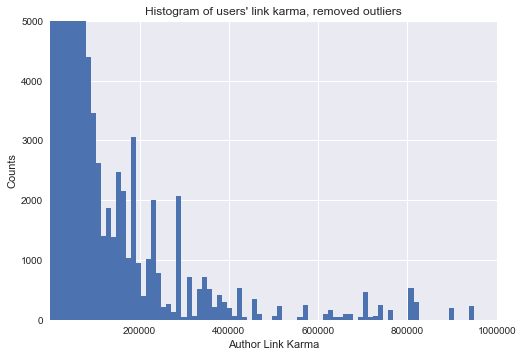

In [194]:
fig, ax = plt.subplots()
plt.hist(df.Author_link_karma, bins = 500)
plt.ylim(0, 5000)
plt.xlim(5,1000000)
ax.set_xlabel('Author Link Karma')
ax.set_ylabel('Counts')
ax.set_title("Histogram of users' link karma, removed outliers")

Text(0.5, 1.0, "Histogram of users' link karma, yscale log")

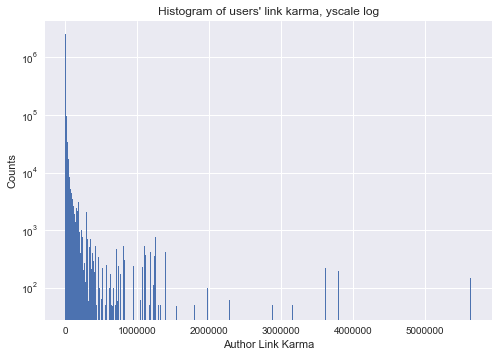

In [195]:
fig, ax = plt.subplots()
plt.hist(df.Author_link_karma, bins = 500)
# plt.ylim(0, 5000)
# plt.xlim(5,1000000)

ax.set_yscale('log')

ax.set_xlabel('Author Link Karma')
ax.set_ylabel('Counts')
ax.set_title("Histogram of users' link karma, yscale log")

Text(0.5, 1.0, "Histogram of users' link karma, outliers removed yscale log")

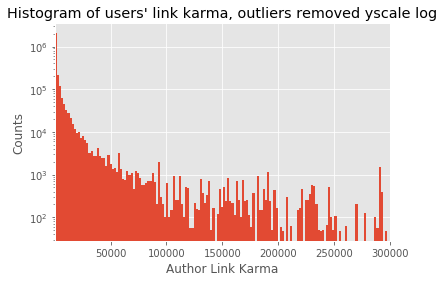

In [160]:
fig, ax = plt.subplots()
plt.hist(df.Author_link_karma, bins = 3000)
# plt.ylim()
plt.xlim(1,300000)

ax.set_yscale('log')

ax.set_xlabel('Author Link Karma')
ax.set_ylabel('Counts')
ax.set_title("Histogram of users' link karma, outliers removed yscale log")

Text(0.5, 1.0, "Histogram of users' comment karma, removed outliers")

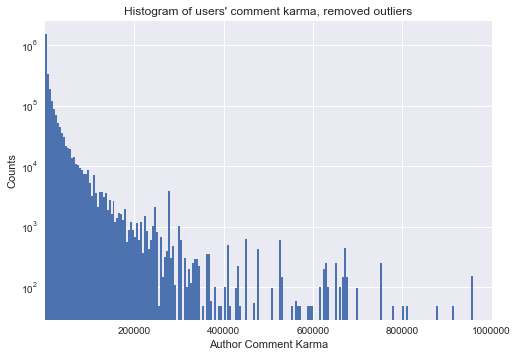

In [204]:
fig, ax = plt.subplots()
plt.hist(df.Author_Comment_Karma, bins = 500)
# plt.ylim(0, 5000)
plt.xlim(1,1000000)

ax.set_yscale('log')
ax.set_xlabel('Author Comment Karma')
ax.set_ylabel('Counts')
ax.set_title("Histogram of users' comment karma, removed outliers")

(0, 1500000)

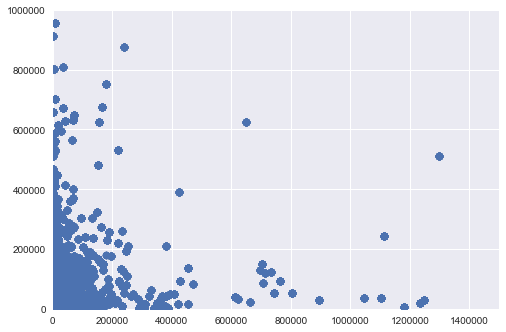

In [207]:
fig, ax = plt.subplots()

plt.scatter(df_test.Author_link_karma, df_test.Author_Comment_Karma)

# ax.set_yscale('')

ax.set_ylim(0, 1000000)
ax.set_xlim(0, 1500000)

Text(0.5, 1.0, 'Histogram of posts per hour of day')

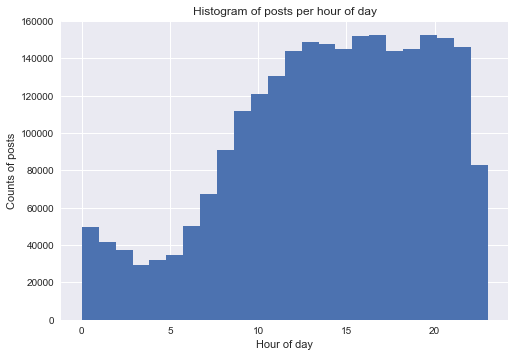

In [192]:
fig, ax = plt.subplots()

plt.hist(df_test.Time.dt.hour, bins = 24)
plt.style.use('seaborn')
ax.set_ylabel('Counts of posts')
ax.set_xlabel('Hour of day')
ax.set_title('Histogram of posts per hour of day')

In [1]:
df_test['Time'].dt.hour

NameError: name 'df_test' is not defined

In [205]:
df_test

,Text,ID,Subreddit,meta,Time,Username,Upvotes,Downvotes,Author_link_karma,Author_Comment_Karma,Author_has_gold?
4,disclaim think obama nomin someon senat hold c...,d028c5d,politics,news,2016-02-16 13:25:06,degausse,3.0,0.0,1.0,1941.0,0.0
6,either way process drag elect gop vote senat s...,d026od6,politics,news,2016-02-16 12:47:45,cyberspyder,5.0,0.0,1300.0,6462.0,1.0
7,republican alway battl sever case select amnesia,d026wk3,politics,news,2016-02-16 12:52:49,jabb0,15.0,0.0,44981.0,141501.0,0.0
8,polit differ back peopl side least pretend rea...,d02a3k3,politics,news,2016-02-16 14:04:12,Hypertension123456,2.0,0.0,46.0,42036.0,0.0
9,equal ridicul 1970 law review articl mcconnel ...,d025wad,politics,news,2016-02-16 12:30:13,trash_reason,26.0,0.0,5613.0,1361.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2725995,woefulli bad sens direct use advic hand time p...,d02c1s1,minecraft,gaming,2016-02-16 14:46:51,capfan67,2.0,0.0,178.0,2518.0,0.0
2725996,charact hand first person invis look glitchi u...,464kj4,minecraft,gaming,2016-02-16 15:01:34,CookiezFort,0.0,0.0,833.0,3248.0,0.0
2725997,guess either shader use featur ad 18 glsl vers...,d02cxvk,minecraft,gaming,2016-02-16 15:06:52,Huntron,1.0,0.0,5534.0,3062.0,1.0
2725998,guess tri use brand spank new graphic driver n...,d02ic1n,minecraft,gaming,2016-02-16 17:11:31,nothingl_,1.0,0.0,104.0,807.0,0.0


In [ ]:
import itertools

words = clean_df['Text'].str.lower().str.findall("\w+")
words = list(itertools.chain(words))
unique = set(words)
print(unique)